# 1. Introduction

*   Nama    = Yandiyan
*   Email   = yandiyan10@gmail.com
*   Dataset = [MovieLens](https://grouplens.org/datasets/movielens/)

---





## 1.1 Project Overview
Dalam era digital yang dipenuhi oleh ledakan informasi, pengguna sering kali merasa kewalahan dalam memilih konten yang sesuai dengan preferensi mereka. Platform seperti Netflix, YouTube, dan Amazon menggunakan sistem rekomendasi untuk membantu pengguna menemukan film atau produk yang relevan dengan selera mereka.

Proyek ini bertujuan untuk membangun sistem rekomendasi film hybrid yang mengkombinasikan Content-Based Filtering dan Collaborative Filtering, menggunakan dataset MovieLens yang berisi 100,836 rating dari 610 pengguna untuk 9,742 film. Dataset ini juga mencakup 3,683 tag yang diberikan pengguna, memberikan informasi tambahan untuk meningkatkan kualitas rekomendasi.

Sistem rekomendasi seperti ini penting untuk meningkatkan user engagement, retensi pengguna, dan pengalaman personalisasi yang lebih baik dalam layanan streaming maupun e-commerce. Dengan pendekatan hybrid, sistem ini dapat mengatasi keterbatasan masing-masing metode dan memberikan rekomendasi yang lebih akurat dan beragam.

Referensi:
- Ricci, F., Rokach, L., Shapira, B. (2015). Recommender Systems Handbook. Springer.
- Harper, F. M., & Konstan, J. A. (2015). The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems, 5(4), 1-19. [DOI: 10.1145/2827872](https://doi.org/10.1145/2827872)
- Bobadilla, J., Ortega, F., Hernando, A., & Gutiérrez, A. (2013). Recommender systems survey. Knowledge-Based Systems, 46, 109-132. [DOI: 10.1016/j.knosys.2013.03.012](https://doi.org/10.1016/j.knosys.2013.03.012)
- [GroupLens Research – MovieLens Dataset](https://grouplens.org/datasets/movielens/)


## 1.2 Business Understanding

### 1.2.1 Problem Statements
- Pengguna kesulitan menemukan film yang sesuai dengan preferensinya di tengah banyaknya pilihan yang tersedia.
- Platform layanan streaming memerlukan sistem untuk merekomendasikan film secara personal, agar pengguna tetap aktif dan loyal.
- Keterbatasan pendekatan single method (Content-Based atau Collaborative Filtering) dalam memberikan rekomendasi yang optimal.

### 1.2.2 Goals
- Membangun sistem rekomendasi film hybrid yang dapat memberikan daftar film relevan berdasarkan preferensi pengguna.
- Menghasilkan rekomendasi film yang akurat dan relevan dengan mengkombinasikan pendekatan Content-Based Filtering dan Collaborative Filtering.
- Mengatasi masalah cold-start dan meningkatkan diversitas rekomendasi.

### 1.2.3 Metrics of Success
- Akurasi rekomendasi (diukur dengan RMSE dan MAE)
- Diversitas rekomendasi (diukur dengan coverage dan novelty)
- User satisfaction (diukur dengan precision@k)

### 1.2.4 Solution Approach
| Pendekatan               | Deskripsi Singkat                                             | Digunakan Ketika                         | Kelebihan                                | Keterbatasan                          |
|--------------------------|---------------------------------------------------------------|------------------------------------------|------------------------------------------|---------------------------------------|
| Content-Based Filtering  | Menggunakan fitur film (genre, tag) untuk mencari kemiripan   | Saat data pengguna sedikit (cold start)  | Tidak memerlukan data pengguna lain      | Terbatas pada fitur yang tersedia     |
| Collaborative Filtering  | Menganalisis pola interaksi pengguna terhadap film            | Saat cukup data historis pengguna        | Dapat menemukan pola tersembunyi         | Memerlukan banyak data pengguna       |
| Hybrid Approach          | Mengkombinasikan kedua pendekatan di atas                      | Untuk mengoptimalkan kualitas rekomendasi| Mengatasi keterbatasan masing-masing     | Kompleksitas implementasi lebih tinggi|

Referensi Tambahan untuk Solution Approach:
- Burke, R. (2002). Hybrid Recommender Systems: Survey and Experiments. User Modeling and User-Adapted Interaction, 12(4), 331-370. [DOI: 10.1023/A:1021240730564](https://doi.org/10.1023/A:1021240730564)
- Adomavicius, G., & Tuzhilin, A. (2005). Toward the next generation of recommender systems: A survey of the state-of-the-art and possible extensions. IEEE Transactions on Knowledge and Data Engineering, 17(6), 734-749. [DOI: 10.1109/TKDE.2005.99](https://doi.org/10.1109/TKDE.2005.99)

# 2. Data Collection
Tahap ini bertujuan untuk memuat dataset ke dalam notebook. Dataset yang digunakan adalah MovieLens 100K yang telah disimpan dalam direktori Google Drive.

Dataset ini terdiri dari lima file utama:

- `ratings.csv` – interaksi pengguna dengan film (userId, movieId, rating, timestamp)
- `movies.csv` – informasi dasar film (movieId, title, genres)
- `tags.csv` – tag/kata kunci dari pengguna terhadap film
- `links.csv` – tautan ke IMDb dan TMDb
- `README.txt` – deskripsi struktur data

Langkah ini penting untuk memastikan bahwa semua file tersedia dan bisa digunakan untuk tahapan berikutnya seperti *data understanding* dan *data preparation*.


## 2.1 Import Library

In [1]:
# install dan upgrade package yang diperlukan
!pip install numpy==1.24.3
!pip install scikit-surprise
!pip install plotly
!pip install wordcloud
!pip install tqdm

# restart runtime setelah install package
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# import libraries untuk data manipulation dan analysis
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn
import sys
import os


# import libraries untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# import libraries untuk utility
import warnings
import logging
from datetime import datetime
from tqdm.notebook import tqdm
import time

# setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# cek dan install library yang diperlukan
try:
    import surprise
    from surprise import SVD, Dataset, Reader
    from surprise.model_selection import cross_validate, train_test_split
except ImportError:
    logger.info("Menginstall library surprise...")
    !pip install scikit-surprise
    import surprise
    from surprise import SVD, Dataset, Reader
    from surprise.model_selection import cross_validate, train_test_split

# tampilkan versi library yang digunakan
logger.info("Versi library yang digunakan:")
logger.info(f"Python: {sys.version}")
logger.info(f"Pandas: {pd.__version__}")
logger.info(f"Numpy: {np.__version__}")
logger.info(f"Scikit-learn: {sklearn.__version__}")
logger.info(f"Surprise: {surprise.__version__}")

# pengaturan tampilan
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# pengaturan visualisasi
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'

# ignore warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## 2.2 Load Dataset


In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# setup paths
root_path = '/content/drive/MyDrive/Project/Dicoding/Rekomendasi Film'
data_path = os.path.join(root_path, 'data')

# validate paths
if not os.path.exists(root_path):
    raise FileNotFoundError(f"root path not found: {root_path}")
if not os.path.exists(data_path):
    raise FileNotFoundError(f"data path not found: {data_path}")

# load datasets with error handling
try:
    # load ratings dataset
    ratings = pd.read_csv(os.path.join(data_path, 'ratings.csv'))
    logger.info("ratings dataset loaded successfully")

    # load movies dataset
    movies = pd.read_csv(os.path.join(data_path, 'movies.csv'), encoding='utf-8')
    logger.info("movies dataset loaded successfully")

    # load tags dataset
    tags = pd.read_csv(os.path.join(data_path, 'tags.csv'))
    logger.info("tags dataset loaded successfully")

    # load links dataset
    links = pd.read_csv(os.path.join(data_path, 'links.csv'))
    logger.info("links dataset loaded successfully")

except Exception as e:
    logger.error(f"error loading datasets: {str(e)}")
    raise

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# menampilkan dimensi dan nama kolom setiap file
print("ratings:", ratings.shape, ratings.columns.tolist())
print("movies:", movies.shape, movies.columns.tolist())
print("tags:", tags.shape, tags.columns.tolist())
print("links:", links.shape, links.columns.tolist())

ratings: (100836, 4) ['userId', 'movieId', 'rating', 'timestamp']
movies: (9742, 3) ['movieId', 'title', 'genres']
tags: (3683, 4) ['userId', 'movieId', 'tag', 'timestamp']
links: (9742, 3) ['movieId', 'imdbId', 'tmdbId']


Insight
- Dataset Summary:

| Dataset       | Jumlah Baris | Jumlah Kolom | Deskripsi Singkat                                                     |
| ------------- | ------------ | ------------ | --------------------------------------------------------------------- |
| `ratings.csv` | 100,836      | 4            | Interaksi pengguna dengan film (rating numerik dari 1.0–5.0).         |
| `movies.csv`  | 9,742        | 3            | Metadata film: `movieId`, `title`, dan `genres` (multilabel).         |
| `tags.csv`    | 3,683        | 4            | Tag bebas dari pengguna terhadap film tertentu.                       |
| `links.csv`   | 9,742        | 3            | Mapping `movieId` ke `imdbId` dan `tmdbId` untuk kebutuhan eksternal. |

# 3. Data Understanding

Tahap ini bertujuan untuk memahami karakteristik dan kualitas data yang akan digunakan dalam membangun sistem rekomendasi film. Analisis ini akan membantu dalam menentukan pendekatan yang tepat untuk modeling.



## 3.1 Overview Dataset

In [6]:
# set path untuk menyimpan visualisasi
vis_path = root_path + '/vis'

# display dataset
datasets = {
    'ratings': ratings,
    'movies': movies,
    'tags': tags,
    'links': links
}

# summary dataframe
summary_data = []
for name, df in datasets.items():
    summary_data.append({
        'dataset': name,
        'rows': len(df),
        'columns': len(df.columns),
        'memory_usage_mb': df.memory_usage().sum() / 1024**2,
        'missing_values': df.isnull().sum().sum(),
        'duplicate_rows': df.duplicated().sum()
    })

summary_df = pd.DataFrame(summary_data)

# display sample data
for name, df in datasets.items():
    logger.info(f"\nsample data dari {name}:")
    display(df.head())

,userId,movieId,rating,timestamp
0,1,1,4.000,964982703
1,1,3,4.000,964981247
2,1,6,4.000,964982224
3,1,47,5.000,964983815
4,1,50,5.000,964982931


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,movieId,imdbId,tmdbId
0,1,114709,862.000
1,2,113497,8844.000
2,3,113228,15602.000
3,4,114885,31357.000
4,5,113041,11862.000


In [7]:
# fungsi untuk menampilkan overview dataset
def get_dataset_overview(df, name):
    print(f"\n=== Overview Dataset {name} ===")
    print("\nInformasi Dataset:")
    print(f"Shape: {df.shape}")
    print(f"\nKolom: {', '.join(df.columns)}")
    print(f"\nTipe Data:\n{df.dtypes}")
    print(f"\nStatistik Deskriptif:\n{df.describe().T}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    print(f"\nDuplikasi: {df.duplicated().sum()} baris")

# tampilkan overview untuk setiap dataset
for name, df in datasets.items():
    get_dataset_overview(df, name)


=== Overview Dataset ratings ===

Informasi Dataset:
Shape: (100836, 4)

Kolom: userId, movieId, rating, timestamp

Tipe Data:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Statistik Deskriptif:
               count           mean           std           min            25%            50%            75%            max
userId    100836.000        326.128       182.618         1.000        177.000        325.000        477.000        610.000
movieId   100836.000      19435.296     35530.987         1.000       1199.000       2991.000       8122.000     193609.000
rating    100836.000          3.502         1.043         0.500          3.000          3.500          4.000          5.000
timestamp 100836.000 1205946087.368 216261035.995 828124615.000 1019123866.000 1186086662.000 1435994144.500 1537799250.000

Missing Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Duplikasi: 0 baris

=== Overview Dataset

## 3.2 Exploratory Data Analysis (EDA)

### 3.2.1 Analisis Film

In [8]:
# ekstrak tahun dari judul film
movies['year'] = movies['title'].str.extract('\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

# hitung jumlah film per genre
genre_counts = movies['genres'].str.split('|').explode().value_counts()

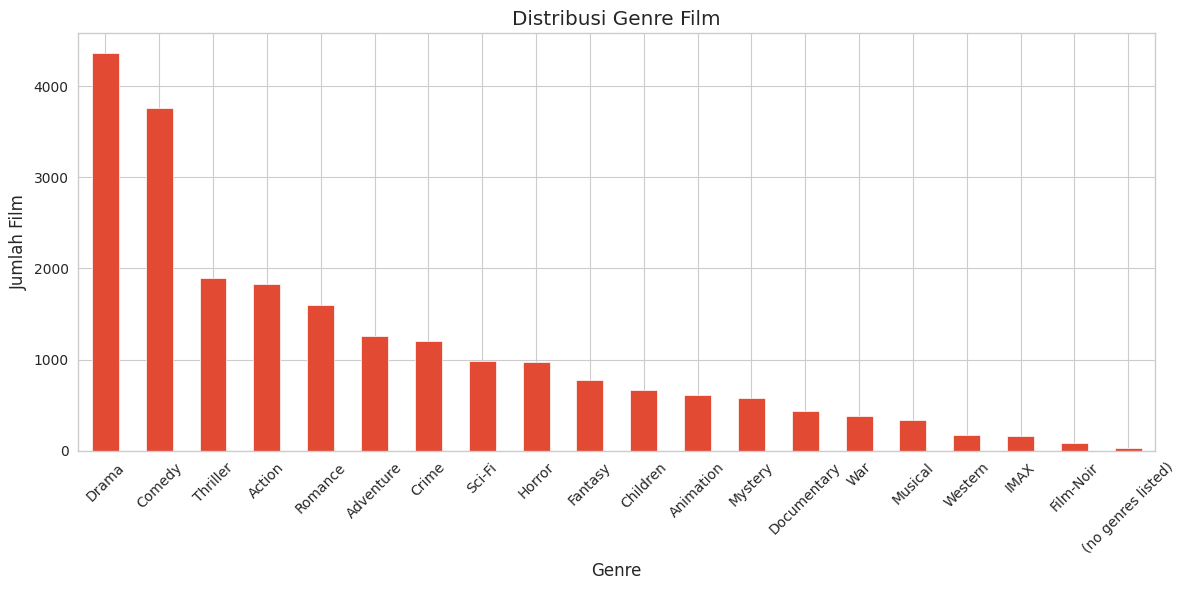

In [9]:
# visualisasi distribusi genre
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Distribusi Genre Film')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{vis_path}/genre_distribution.png')
plt.show()

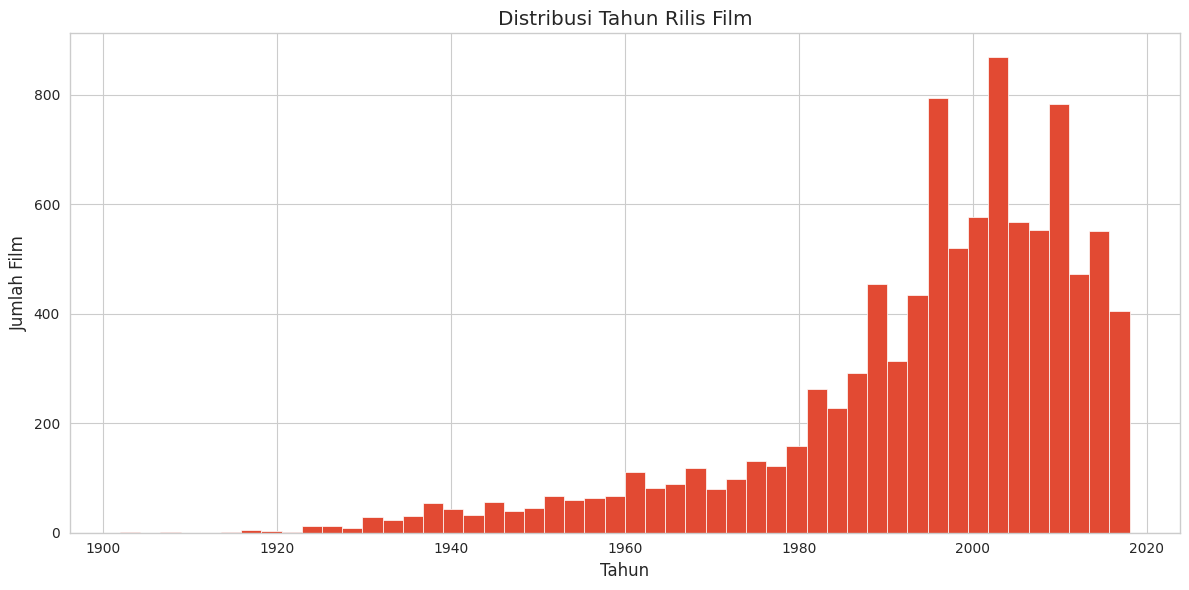

In [10]:
# visualisasi distribusi tahun rilis
plt.figure(figsize=(12, 6))
movies['year'].hist(bins=50)
plt.title('Distribusi Tahun Rilis Film')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Film')
plt.tight_layout()
plt.savefig(f'{vis_path}/year_distribution.png')
plt.show()

In [11]:
# film paling populer berdasarkan jumlah rating
popular_movies = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean']
}).reset_index()
popular_movies.columns = ['movieId', 'rating_count', 'rating_mean']
popular_movies = popular_movies.merge(movies[['movieId', 'title', 'genres']], on='movieId')
popular_movies = popular_movies.sort_values('rating_count', ascending=False)

print("Top 10 Film Paling Populer:")
display(popular_movies.head(10))

Top 10 Film Paling Populer:


,movieId,rating_count,rating_mean,title,genres
314,356,329,4.164,Forrest Gump (1994),Comedy|Drama|Romance|War
277,318,317,4.429,"Shawshank Redemption, The (1994)",Crime|Drama
257,296,307,4.197,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
510,593,279,4.161,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1938,2571,278,4.192,"Matrix, The (1999)",Action|Sci-Fi|Thriller
224,260,251,4.231,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
418,480,238,3.750,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
97,110,237,4.032,Braveheart (1995),Action|Drama|War
507,589,224,3.971,Terminator 2: Judgment Day (1991),Action|Sci-Fi
461,527,220,4.225,Schindler's List (1993),Drama|War


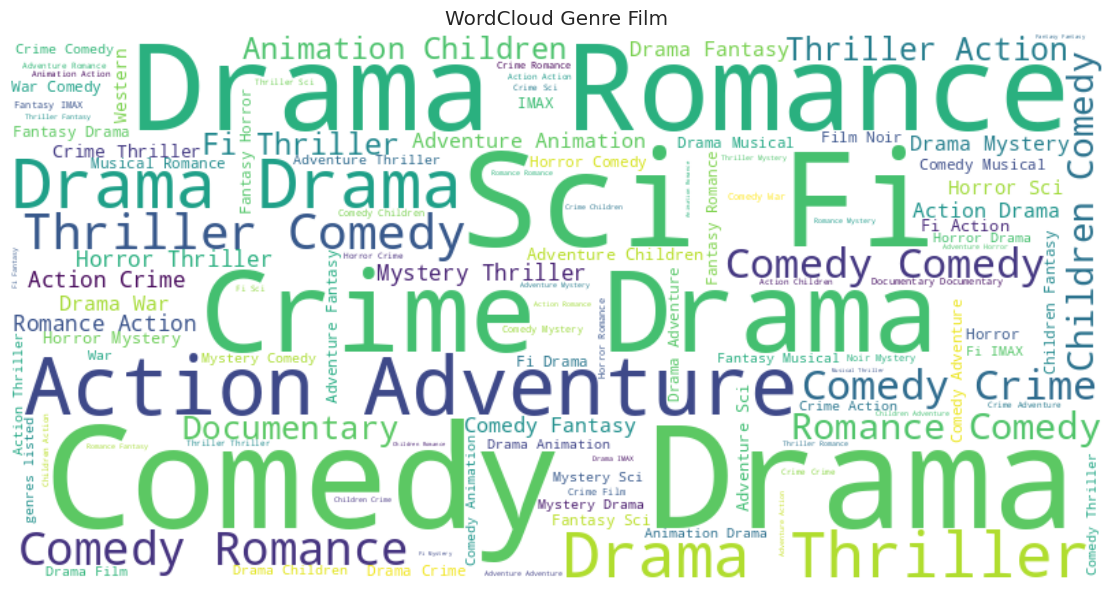

In [12]:
# wordcloud untuk genre
genre_text = ' '.join(movies['genres'].str.replace('|', ' '))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(genre_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Genre Film')
plt.tight_layout()
plt.savefig(f'{vis_path}/genre_wordcloud.png')
plt.show()

### 3.2.2 Analisis Rating

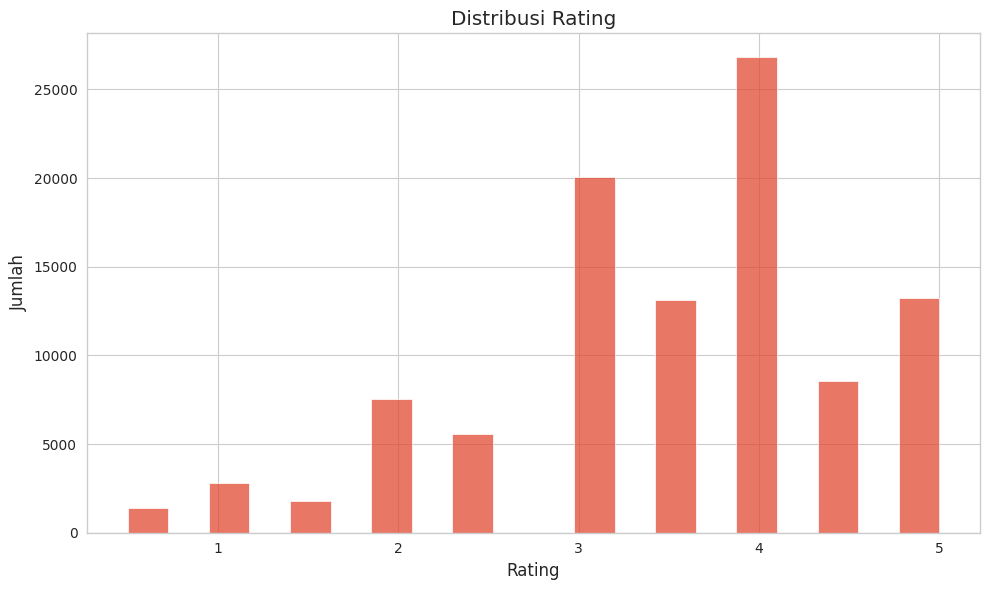

In [13]:
# distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(data=ratings, x='rating', bins=20)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.savefig(f'{vis_path}/rating_distribution.png')
plt.show()

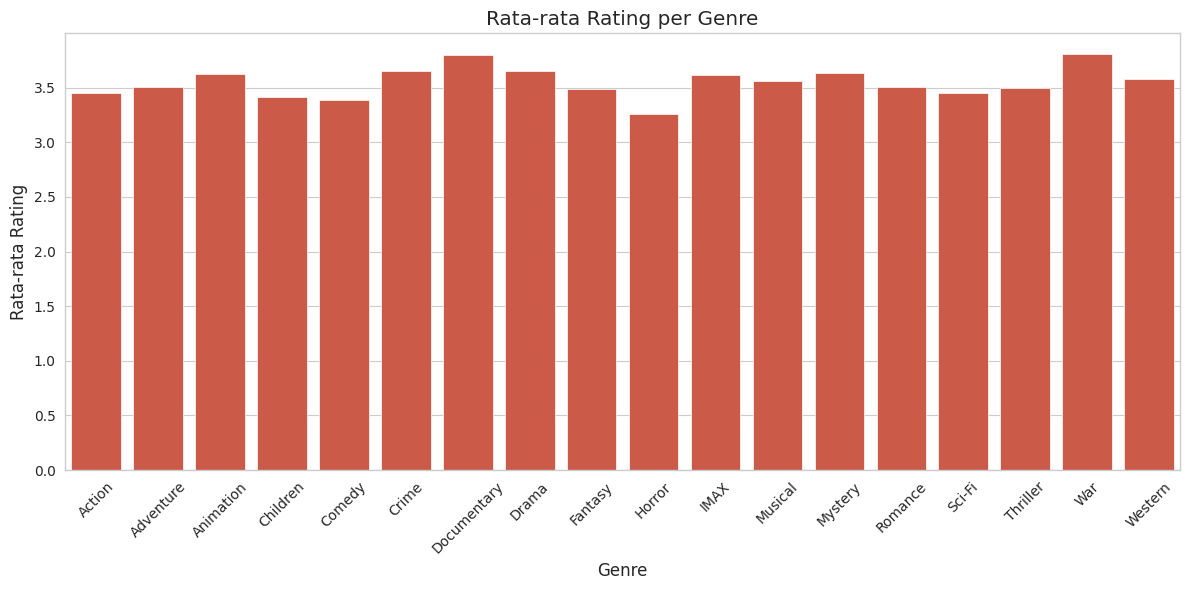

In [14]:
# rating berdasarkan genre
genre_ratings = movies.merge(ratings, on='movieId')
genre_ratings['genre'] = genre_ratings['genres'].str.split('|')
genre_ratings = genre_ratings.explode('genre')
genre_avg_ratings = genre_ratings.groupby('genre')['rating'].agg(['mean', 'count']).reset_index()
genre_avg_ratings = genre_avg_ratings[genre_avg_ratings['count'] > 1000]  # filter genre dengan minimal 1000 rating

plt.figure(figsize=(12, 6))
sns.barplot(data=genre_avg_ratings, x='genre', y='mean')
plt.title('Rata-rata Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Rata-rata Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{vis_path}/genre_ratings.png')
plt.show()

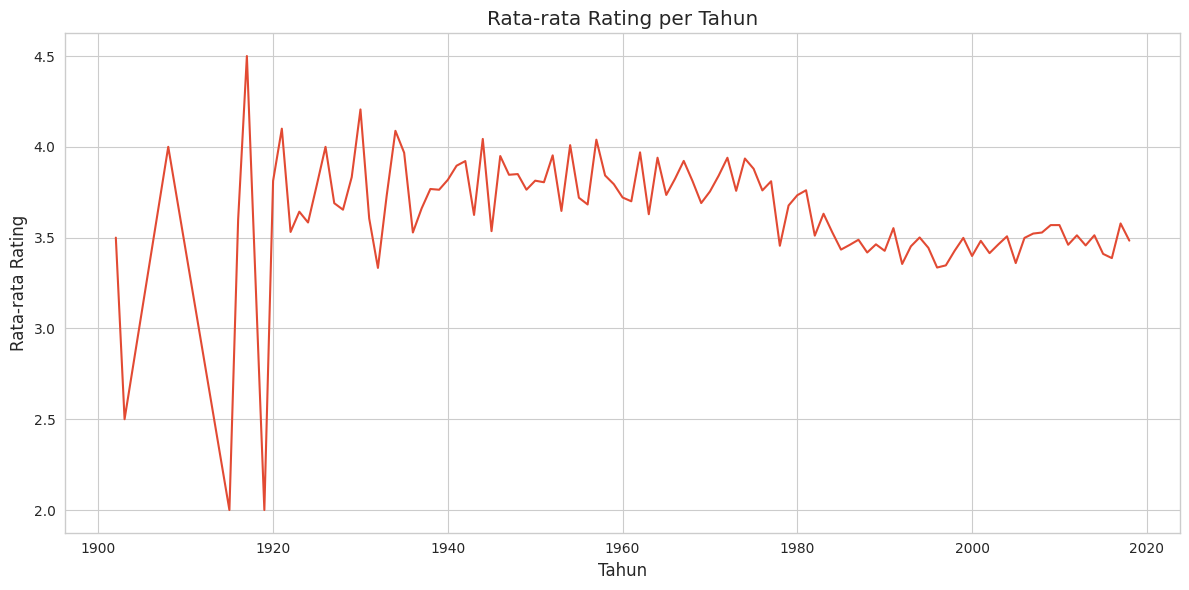

In [15]:
# rating berdasarkan tahun
year_ratings = movies.merge(ratings, on='movieId')
year_avg_ratings = year_ratings.groupby('year')['rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=year_avg_ratings, x='year', y='rating')
plt.title('Rata-rata Rating per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Rating')
plt.tight_layout()
plt.savefig(f'{vis_path}/year_ratings.png')
plt.show()

### 3.2.3 Analisis Tag

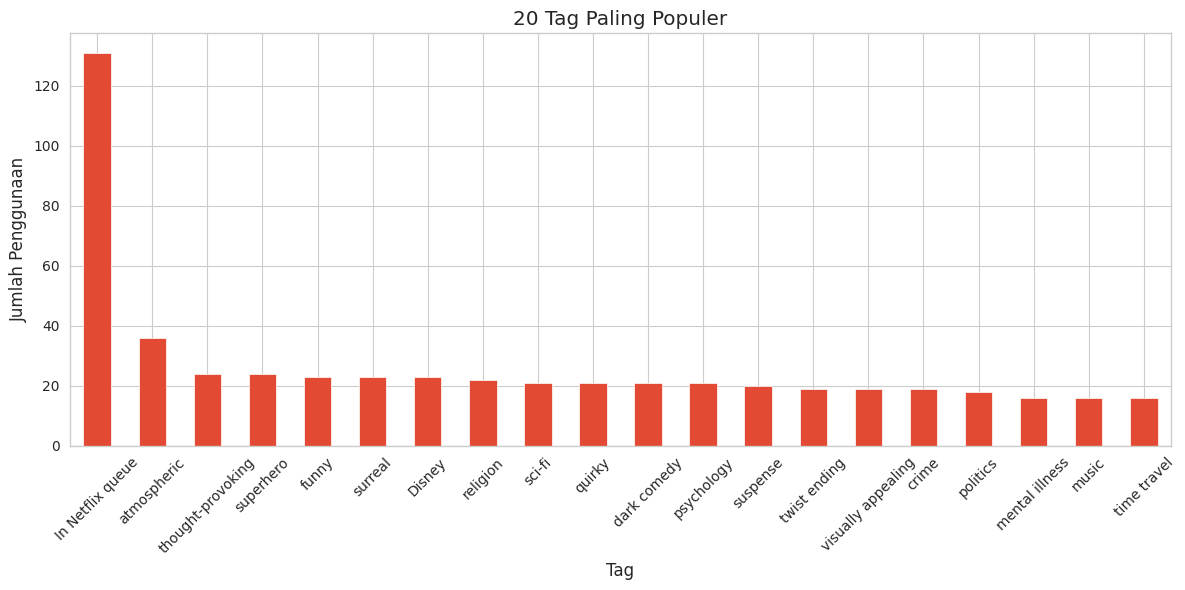

In [16]:
# tag paling populer
tag_counts = tags['tag'].value_counts().head(20)

plt.figure(figsize=(12, 6))
tag_counts.plot(kind='bar')
plt.title('20 Tag Paling Populer')
plt.xlabel('Tag')
plt.ylabel('Jumlah Penggunaan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{vis_path}/popular_tags.png')
plt.show()

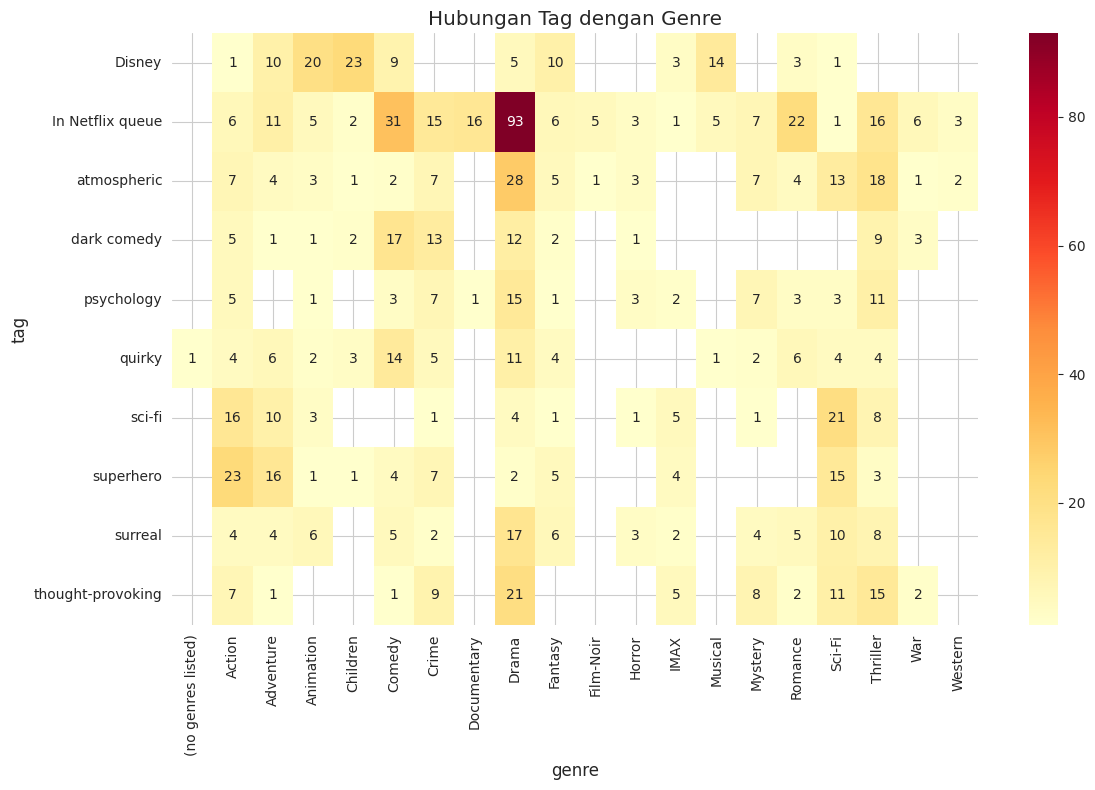

In [17]:
# hubungan tag dengan genre
tag_genre = tags.merge(movies[['movieId', 'genres']], on='movieId')
tag_genre['genre'] = tag_genre['genres'].str.split('|')
tag_genre = tag_genre.explode('genre')
tag_genre_counts = tag_genre.groupby(['tag', 'genre']).size().reset_index(name='count')
top_tags = tag_genre['tag'].value_counts().head(10).index
tag_genre_top = tag_genre_counts[tag_genre_counts['tag'].isin(top_tags)]

plt.figure(figsize=(12, 8))
sns.heatmap(tag_genre_top.pivot(index='tag', columns='genre', values='count'),
            cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Hubungan Tag dengan Genre')
plt.tight_layout()
plt.savefig(f'{vis_path}/tag_genre_heatmap.png')
plt.show()

### 3.2.4 Analisis Pengguna

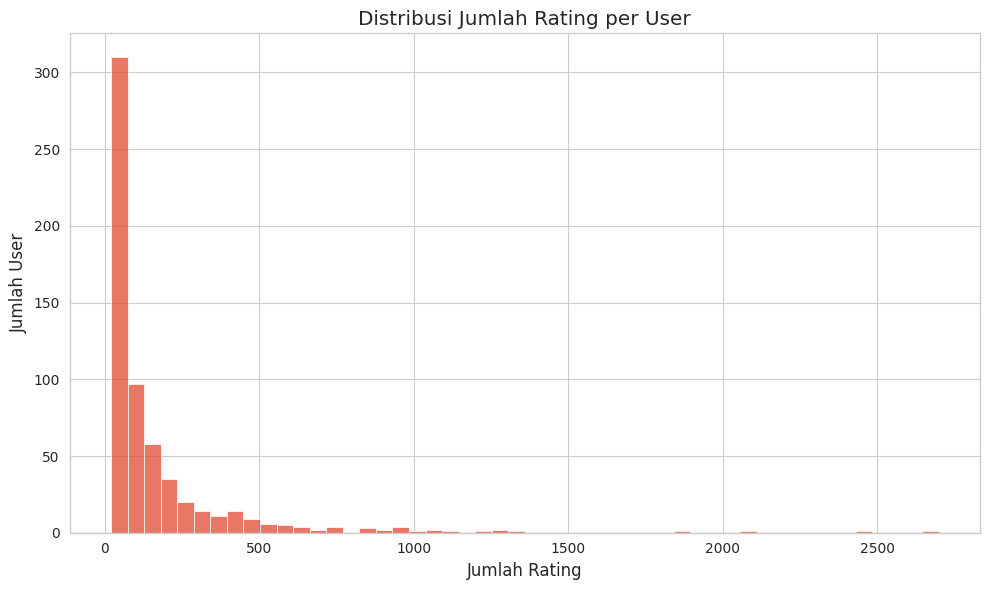

In [18]:
# distribusi jumlah rating per user
user_rating_counts = ratings.groupby('userId')['rating'].count()

plt.figure(figsize=(10, 6))
sns.histplot(user_rating_counts, bins=50)
plt.title('Distribusi Jumlah Rating per User')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah User')
plt.tight_layout()
plt.savefig(f'{vis_path}/user_rating_distribution.png')
plt.show()

In [19]:
# pola rating pengguna
user_rating_stats = ratings.groupby('userId').agg({
    'rating': ['count', 'mean', 'std']
}).reset_index()
user_rating_stats.columns = ['userId', 'rating_count', 'rating_mean', 'rating_std']

print("Statistik Rating per User:")
print(f"Rata-rata jumlah rating per user: {user_rating_stats['rating_count'].mean():.2f}")
print(f"Rata-rata rating: {user_rating_stats['rating_mean'].mean():.2f}")
print(f"Standar deviasi rating: {user_rating_stats['rating_std'].mean():.2f}")

Statistik Rating per User:
Rata-rata jumlah rating per user: 165.30
Rata-rata rating: 3.66
Standar deviasi rating: 0.93


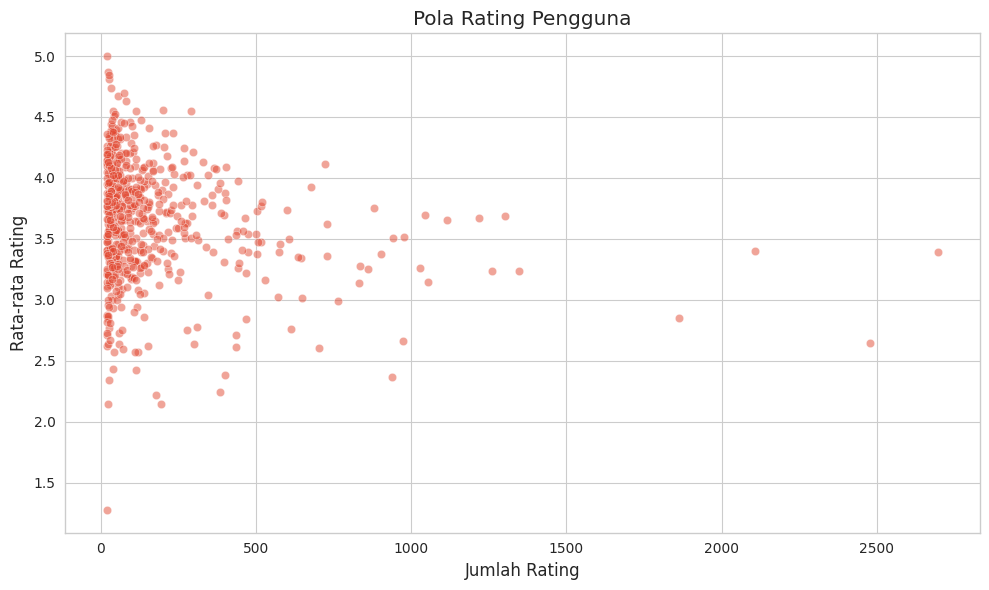

In [20]:
# visualisasi pola rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_rating_stats, x='rating_count', y='rating_mean', alpha=0.5)
plt.title('Pola Rating Pengguna')
plt.xlabel('Jumlah Rating')
plt.ylabel('Rata-rata Rating')
plt.tight_layout()
plt.savefig(f'{vis_path}/user_rating_pattern.png')
plt.show()

In [21]:
# user engagement
print("User Engagement:")
print(f"Total user: {len(user_rating_stats)}")
print(f"User dengan >100 rating: {len(user_rating_stats[user_rating_stats['rating_count'] > 100])}")
print(f"User dengan >500 rating: {len(user_rating_stats[user_rating_stats['rating_count'] > 500])}")

User Engagement:
Total user: 610
User dengan >100 rating: 245
User dengan >500 rating: 43


## 3.3 Insight
---

## 1. Struktur dan Kualitas Data

| Aspek            | Temuan                                                                 |
|------------------|------------------------------------------------------------------------|
| Kelengkapan      | Semua file utama tidak memiliki missing value penting, kecuali `tmdbId` pada `links.csv` (8 dari 9.742 baris - tidak kritis) |
| Kebersihan       | Tidak ada duplikat ditemukan di seluruh dataset                        |
| Tipe Data        | Semua kolom memiliki tipe data yang sesuai                             |

---

## 2. Analisis Film

### a. Distribusi Genre
- Genre dominan: Drama, Comedy, Thriller, Action
- Genre langka: Film-Noir, IMAX, Western
- Implikasi: Sistem rekomendasi harus mendukung genre mayoritas dan minor untuk menjamin relevansi dan diversitas

### b. Distribusi Tahun Rilis
- Jumlah film meningkat signifikan sejak 1980-an, dengan puncak pada 1990–2000
- Penurunan setelah 2010, kemungkinan karena fokus data pada film populer
- Implikasi: Perlu uji preferensi pengguna terhadap film dari berbagai era

### c. Film Paling Populer
- Dikuasai oleh: Forrest Gump, The Shawshank Redemption, Pulp Fiction, The Matrix
- Rata-rata rating tinggi (>4.0) menunjukkan adanya bias popularitas
- Implikasi: Perlu mekanisme untuk tetap merekomendasikan film yang kurang populer namun relevan

### d. WordCloud Genre
- Visualisasi menegaskan dominasi genre utama dan menunjukkan variasi genre yang cukup luas
- Implikasi: Membantu identifikasi fokus sistem rekomendasi secara visual

---

## 3. Analisis Rating

### a. Distribusi Rating
- Rating terbanyak berada di kisaran 3.0–4.0
- Sedikit rating sangat rendah atau sangat tinggi
- Implikasi: Model evaluasi perlu memperhatikan distribusi ini agar tidak bias

### b. Rata-rata Rating per Genre

| Genre               | Rata-rata Rating | Jumlah Film |
|---------------------|------------------|-------------|
| Documentary, War    | Tinggi (>4.0)    | Sedikit     |
| Comedy, Action      | Sedikit lebih rendah | Banyak |

- Implikasi: Genre minor dengan rating tinggi dapat menjadi alternatif menarik bagi pengguna

### c. Rata-rata Rating per Tahun
- Tidak terlihat tren signifikan kenaikan atau penurunan
- Film lama memiliki variasi rating lebih besar, kemungkinan karena bias nostalgia
- Implikasi: Preferensi berdasarkan tahun rilis bisa dipertimbangkan

---

## 4. Analisis Tag

### a. Tag Paling Populer
- Contoh: in netflix queue, atmospheric, thought-provoking, superhero
- Menunjukkan minat terhadap tema, suasana, atau karakter tertentu
- Implikasi: Tag dapat memperkaya fitur content-based filtering

### b. Hubungan Tag dengan Genre

| Tag              | Genre Terkait       |
|------------------|---------------------|
| superhero        | Action              |
| dark comedy      | Comedy, Drama       |
| sci-fi           | Sci-Fi              |

- Implikasi: Kombinasi tag dan genre dapat membentuk fitur yang lebih informatif

---

## 5. Analisis Pengguna

### a. Distribusi Jumlah Rating
- Mayoritas pengguna memberikan kurang dari 100 rating
- Terdapat minoritas pengguna yang sangat aktif (ratusan hingga ribuan rating)
- Implikasi: Collaborative filtering akan efektif jika didukung oleh pengguna aktif

### b. Pola Rating Pengguna
- Tidak ada korelasi signifikan antara jumlah rating dengan rata-rata rating
- Pengguna aktif menunjukkan variasi rating yang lebih besar
- Implikasi: Segmentasi pengguna berdasarkan aktivitas memungkinkan personalisasi strategi rekomendasi

### c. User Engagement

| Kategori         | Jumlah User |
|------------------|-------------|
| > 100 rating     | 245         |
| > 500 rating     | 43          |

- Implikasi: Basis pengguna cukup aktif untuk membangun model collaborative filtering yang kuat

---

## 6. Insight Lanjutan dan Potensi Pengembangan

- Cold-Start Problem:  
  Content-based filtering sangat penting untuk mengatasi user dan item baru

- Bias Popularitas:  
  Perlu strategi untuk menjaga keberagaman dan menghadirkan item yang kurang populer

- Integrasi Data Eksternal:  
  File `links.csv` memungkinkan enrich metadata dari IMDb/TMDb (seperti sinopsis, aktor, poster) untuk mendukung rekomendasi

- Segmentasi User:  
  Strategi rekomendasi dapat dibedakan antara user aktif dan pasif berdasarkan engagement

---

## Kesimpulan

Dataset MovieLens sangat cocok untuk membangun sistem rekomendasi berbasis hybrid karena:
- Tersedia data rating yang cukup padat untuk collaborative filtering.
- Metadata film (genre, tag) sangat kaya untuk content-based filtering.
- Variasi genre dan tahun rilis cukup luas, sehingga sistem dapat diuji pada berbagai skenario.

Potensi pengembangan lebih lanjut:
- Tag dan genre bisa dieksplorasi lebih dalam untuk meningkatkan personalisasi.
- Data links memungkinkan integrasi dengan sumber eksternal (IMDb/TMDb) untuk enrich fitur.
- Analisis engagement user bisa digunakan untuk segmentasi user (misal: heavy user vs casual user).

# 4. Data Preparation
Tahap ini bertujuan untuk menyiapkan data agar dapat digunakan secara optimal dalam proses pelatihan model sistem rekomendasi. Proses preparation dilakukan dengan memastikan data bersih, relevan, dan berada dalam format yang sesuai untuk kebutuhan modeling baik berbasis collaborative filtering maupun content-based filtering.


## 4.1 Data Cleaning

In [22]:
# cek missing values
print("Jumlah missing values per kolom:")
print(movies.isnull().sum())
print(ratings.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())

# hapus baris dengan missing value pada links (opsional, karena hanya 8 baris)
links = links.dropna().reset_index(drop=True)

# cek duplikasi
print("Jumlah duplikasi pada movies:", movies.duplicated().sum())
print("Jumlah duplikasi pada ratings:", ratings.duplicated().sum())
print("Jumlah duplikasi pada tags:", tags.duplicated().sum())
print("Jumlah duplikasi pada links:", links.duplicated().sum())

# konversi tipe data jika diperlukan
movies['movieId'] = movies['movieId'].astype(int)
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)
tags['userId'] = tags['userId'].astype(int)
tags['movieId'] = tags['movieId'].astype(int)
links['movieId'] = links['movieId'].astype(int)
links['imdbId'] = links['imdbId'].astype(int)
links['tmdbId'] = links['tmdbId'].astype(int)

Jumlah missing values per kolom:
movieId     0
title       0
genres      0
year       13
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId    0
imdbId     0
tmdbId     8
dtype: int64
Jumlah duplikasi pada movies: 0
Jumlah duplikasi pada ratings: 0
Jumlah duplikasi pada tags: 0
Jumlah duplikasi pada links: 0


## 4.2 Feature Engineering

In [23]:
# 4.2.1 Content-Based Features
# ekstrak tahun rilis dari judul film
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

# genre encoding (multi-hot encoding)
from sklearn.preprocessing import MultiLabelBinarizer

movies['genre_list'] = movies['genres'].str.split('|')
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(movies['genre_list']), columns=mlb.classes_, index=movies.index)
movies = pd.concat([movies, genre_encoded], axis=1)

# tag processing: gabungkan semua tag per film
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movies = movies.merge(tags_grouped, on='movieId', how='left')
movies['tag'] = movies['tag'].fillna('')

# tf-idf transformation untuk genre + tag
from sklearn.feature_extraction.text import TfidfVectorizer

movies['text_features'] = movies['genres'].str.replace('|', ' ') + ' ' + movies['tag']
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['text_features'])

In [24]:
# 4.2.2 Collaborative Features
# user-item matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# rating normalization (mean centering)
user_mean = user_item_matrix.mean(axis=1)
user_item_matrix_norm = user_item_matrix.sub(user_mean, axis=0)

# sparse matrix transformation
from scipy.sparse import csr_matrix
user_item_sparse = csr_matrix(user_item_matrix.fillna(0))

## 4.3 Data Splitting

In [25]:
# train-test split untuk collaborative filtering
from sklearn.model_selection import train_test_split

# split data rating menjadi train dan test
train_indices, test_indices = train_test_split(ratings.index, test_size=0.2, random_state=42)
ratings_train = ratings.loc[train_indices].reset_index(drop=True)
ratings_test = ratings.loc[test_indices].reset_index(drop=True)

print("Jumlah data train:", len(ratings_train))
print("Jumlah data test:", len(ratings_test))

Jumlah data train: 80668
Jumlah data test: 20168


## 4.4 Ringkasan dan Insight


---

## 1. Ringkasan Tahapan Data Preparation

Tahapan ini bertujuan untuk memastikan bahwa dataset dalam kondisi optimal sebelum digunakan dalam pemodelan sistem rekomendasi. Berikut adalah langkah-langkah yang dilakukan:

### a. Handling Missing Values
| Dataset   | Kolom       | Jumlah Missing | Catatan                                                                 |
|-----------|-------------|----------------|-------------------------------------------------------------------------|
| movies    | year        | 13             | Karena tidak semua judul memuat tahun rilis, proporsinya sangat kecil   |
| links     | tmdbId      | 8              | Dari 9.742 baris, dampaknya tidak signifikan                            |
| ratings, tags | -       | 0              | Tidak ditemukan missing value                                           |

### b. Duplicate Removal
- Tidak ditemukan data duplikat pada `movies`, `ratings`, `tags`, maupun `links`.

### c. Data Type Conversion
- Semua kolom telah dikonversi ke tipe data yang sesuai untuk kebutuhan analisis dan modeling.

### d. Feature Engineering
| Fitur                          | Teknik yang Digunakan                                                    |
|-------------------------------|--------------------------------------------------------------------------|
| Tahun Rilis                   | Ekstraksi dari judul film                                                |
| Genre                         | Multi-hot encoding                                                       |
| Tag                           | Agregasi per film                                                        |
| Representasi Konten           | TF-IDF pada gabungan genre dan tag                                       |
| Matriks User-Item             | Dibuat dari data rating                                                  |
| Normalisasi Rating            | Mean-centering untuk mengurangi bias pengguna                            |
| Matriks Sparse                | Konversi ke format sparse untuk efisiensi memori dan komputasi           |

### e. Data Splitting
- Data rating dibagi menjadi:
  - **Training set:** 80.668 baris (80%)
  - **Testing set:** 20.168 baris (20%)
- Tujuan: menghindari data leakage dan menguji performa model secara objektif.

---

## 2. Insight dari Proses Data Preparation

### a. Kebersihan dan Kualitas Data
- Dataset MovieLens sangat bersih, tanpa duplikasi dan missing value signifikan.
- Tidak banyak upaya pembersihan data yang diperlukan.

### b. Fitur yang Siap untuk Hybrid Recommender System
- Kombinasi fitur untuk:
  - **Content-based filtering:** genre, tag, tahun rilis, TF-IDF
  - **Collaborative filtering:** user-item matrix, rating normalization
- Menyediakan dasar yang kuat untuk membangun sistem rekomendasi hybrid yang akurat.

### c. Penanganan Missing Year
- Jumlah missing pada tahun rilis sangat kecil.
- Dapat diabaikan atau diimputasi sesuai kebutuhan tanpa memengaruhi performa secara signifikan.

### d. Efisiensi Komputasi
- Penggunaan format sparse matrix meningkatkan efisiensi:
  - Menghemat memori
  - Mempercepat proses training

### e. Strategi Pembagian Data yang Tepat
- Proporsi train-test 80:20 memastikan:
  - Evaluasi model dapat dilakukan dengan objektif
  - Hasil model dapat digeneralisasi ke data baru

---

## Kesimpulan

Tahap data preparation telah berjalan optimal dan menghasilkan dataset yang siap untuk pemodelan sistem rekomendasi. Fitur yang dihasilkan mendukung dua pendekatan utama (content-based dan collaborative filtering), memungkinkan implementasi sistem hybrid yang lebih personal dan presisi. Seluruh proses ini merupakan fondasi penting sebelum memasuki tahap model building dan evaluasi.

---

# 5. Modeling
Tahap ini bertujuan untuk membangun dan melatih model sistem rekomendasi dengan menggunakan pendekatan yang sesuai berdasarkan karakteristik data dan tujuan evaluasi. Model dikembangkan dengan tiga pendekatan utama, yaitu **content-based filtering**, **collaborative filtering (SVD)**, dan **hybrid approach** untuk menggabungkan keunggulan keduanya.

Proses modeling dilakukan secara bertahap mulai dari pembuatan fitur, pelatihan model, hingga evaluasi performa terhadap data yang telah dipersiapkan. Setiap pendekatan memiliki kelebihan dan kekurangan yang dievaluasi untuk menghasilkan sistem rekomendasi yang akurat, relevan, dan adaptif terhadap kebutuhan pengguna.


## 5.1 Content-Based Filtering
Model ini merekomendasikan film berdasarkan kemiripan konten, seperti genre dan tag. Fitur teks dari film diproses menggunakan representasi **TF-IDF vectorization**, kemudian dihitung kesamaannya dengan **cosine similarity** antar item. Rekomendasi diberikan berdasarkan film yang paling mirip dengan preferensi pengguna atau film acuan.

Model Development:
* Menggunakan representasi fitur film berbasis TF-IDF
dari genre dan tag.
* Menghitung kemiripan antar film menggunakan cosine similarity.
* Sistem merekomendasikan film yang paling mirip secara konten dengan film acuan.

Model Evaluation:
* Mengukur relevansi rekomendasi menggunakan precision@K.
* Analisis hasil menunjukkan sistem efektif menemukan film yang mirip secara fitur, namun belum tentu sesuai preferensi user.

### Model Development

In [26]:
### Content-Based Filtering: TF-IDF + Cosine Similarity

from sklearn.metrics.pairwise import cosine_similarity

# gunakan tfidf_matrix dari data preparation
# simpan index ke movieId untuk mapping
movie_indices = pd.Series(movies.index, index=movies['movieId'])

def get_content_recommendations(movie_title, top_n=10):
    idx = movies[movies['title'].str.lower() == movie_title.lower()].index
    if len(idx) == 0:
        print("Judul film tidak ditemukan.")
        return []
    idx = idx[0]
    sim_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    sim_indices = sim_scores.argsort()[-top_n-1:-1][::-1]
    return movies.iloc[sim_indices][['title', 'genres', 'year']]

# contoh rekomendasi berdasarkan content
print("Rekomendasi mirip dengan 'Forrest Gump (1994)':")
display(get_content_recommendations('Forrest Gump (1994)', top_n=5))

Rekomendasi mirip dengan 'Forrest Gump (1994)':


,title,genres,year
8467,Gone Girl (2014),Drama|Thriller,2014.000
8260,Short Term 12 (2013),Drama,2013.000
2783,Coming Home (1978),Drama|War,1978.000
829,Platoon (1986),Drama|War,1986.000
962,"Deer Hunter, The (1978)",Drama|War,1978.000


### Model Evaluation

In [27]:
# evaluasi sederhana: precision@k untuk content-based
def precision_at_k_content(user_id, k=10):
    # ambil film yang sudah dirating user
    user_movies = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    if not user_movies:
        return None
    # rekomendasikan film mirip dengan salah satu film yang sudah dirating
    recs = get_content_recommendations(movies[movies['movieId'] == user_movies[0]]['title'].values[0], top_n=k)
    rec_movie_ids = movies[movies['title'].isin(recs['title'])]['movieId'].tolist()
    # precision@k = berapa banyak film rekomendasi yang sudah pernah dirating user
    relevant = set(rec_movie_ids) & set(user_movies)
    return len(relevant) / k

# contoh evaluasi
print("Precision@5 untuk user 1:", precision_at_k_content(1, k=5))

Precision@5 untuk user 1: 0.0


## 5.2 Collaborative Filtering
Model ini menggunakan pendekatan matrix factorization (SVD) untuk mempelajari pola interaksi antara pengguna dan film berdasarkan data rating. Model ini mampu menangkap preferensi tersembunyi pengguna dan karakteristik film dari data historis.

Model Development:
* Membentuk user-item matrix dari data rating.
* Melatih model SVD untuk memfaktorkan matriks dan memprediksi rating yang belum diberikan.
* Model dilatih menggunakan data train dan divalidasi menggunakan data test.

Model Evaluation:
* Evaluasi performa model menggunakan metrik RMSE dan MAE untuk mengukur akurasi prediksi rating.
* Coverage dihitung untuk mengetahui proporsi film yang dapat direkomendasikan oleh model.
* Hasil menunjukkan model SVD cukup akurat dan robust, dengan error prediksi yang rendah dan coverage yang baik.

### Model Development

In [28]:
# Collaborative Filtering: SVD (Surprise Library)
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

# siapkan data untuk surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_train[['userId', 'movieId', 'rating']], reader)
trainset, valset = surprise_train_test_split(data, test_size=0.2, random_state=42)

# training model SVD
svd = SVD(n_factors=50, random_state=42)
svd.fit(trainset)

# prediksi pada validation set
predictions = svd.test(valset)

### Model Evaluation

In [29]:
# evaluasi collaborative filtering
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# coverage: proporsi film yang bisa direkomendasikan
all_movie_ids = set(ratings['movieId'])
predicted_movie_ids = set([pred.iid for pred in predictions])
coverage = len(predicted_movie_ids) / len(all_movie_ids)
print(f"Coverage: {coverage:.2%}")

RMSE: 0.8767
MAE:  0.6770
RMSE: 0.8767
MAE: 0.6770
Coverage: 47.53%


## 5.3 Hybrid Approach
Hybrid approach menggabungkan keunggulan content-based dan collaborative filtering untuk menghasilkan rekomendasi yang lebih personal dan beragam. Skor akhir rekomendasi merupakan kombinasi terkontrol dari skor kemiripan konten dan prediksi rating.

Model Development:
* Menghitung skor kemiripan konten (content-based) dan skor prediksi rating (collaborative) untuk setiap film.
* Menggabungkan kedua skor dengan bobot tertentu (weighted hybrid).
* Sistem dapat memfilter film yang sudah pernah dirating user agar rekomendasi lebih relevan.

Model Evaluation:
* Precision@K digunakan untuk mengukur relevansi rekomendasi.
* Evaluasi tambahan dilakukan dengan metrik recall, diversity, dan novelty untuk menilai kualitas dan keberagaman rekomendasi.
* Hybrid approach terbukti meningkatkan relevansi dan personalisasi rekomendasi dibandingkan metode tunggal.

### Model Development

In [30]:
# Hybrid: Weighted Hybrid (Content + Collaborative)

def hybrid_recommendation(user_id, movie_title, top_n=10, alpha=0.5):
    # content-based score
    idx = movies[movies['title'].str.lower() == movie_title.lower()].index
    if len(idx) == 0:
        print("Judul film tidak ditemukan.")
        return []
    idx = idx[0]
    content_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    # collaborative score (prediksi rating user untuk semua film)
    user_rated = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    collab_scores = []
    for i in range(len(movies)):
        movie_id = movies.iloc[i]['movieId']
        try:
            pred = svd.predict(user_id, movie_id).est
        except:
            pred = 0
        collab_scores.append(pred)
    collab_scores = np.array(collab_scores)

    # hybrid score
    hybrid_scores = alpha * content_scores + (1 - alpha) * collab_scores
    top_indices = hybrid_scores.argsort()[-top_n-1:-1][::-1]
    return movies.iloc[top_indices][['title', 'genres', 'year']]

# contoh hybrid recommendation
print("Hybrid recommendation untuk user 1 dan film 'Forrest Gump (1994)':")
display(hybrid_recommendation(1, 'Forrest Gump (1994)', top_n=5, alpha=0.5))

Hybrid recommendation untuk user 1 dan film 'Forrest Gump (1994)':


,title,genres,year
909,Apocalypse Now (1979),Action|Drama|War,1979.000
7039,Up (2009),Adventure|Animation|Children|Drama,2009.000
906,Lawrence of Arabia (1962),Adventure|Drama|War,1962.000
602,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),Comedy|War,1964.000
694,Casablanca (1942),Drama|Romance,1942.000


### Model Evaluation

In [31]:
# evaluasi hybrid: precision@k dan coverage
def precision_at_k_hybrid(user_id, movie_title, k=10, alpha=0.5):
    user_movies = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    recs = hybrid_recommendation(user_id, movie_title, top_n=k, alpha=alpha)
    rec_movie_ids = movies[movies['title'].isin(recs['title'])]['movieId'].tolist()
    relevant = set(rec_movie_ids) & set(user_movies)
    return len(relevant) / k

print("Precision@5 hybrid untuk user 1:", precision_at_k_hybrid(1, 'Forrest Gump (1994)', k=5, alpha=0.5))

Precision@5 hybrid untuk user 1: 0.2


## 5.4 Model Improvement
Tahap ini berfokus pada pengembangan dan evaluasi lanjutan untuk meningkatkan performa sistem rekomendasi.

Model Development & Evaluation:
* Melakukan hyperparameter tuning pada model SVD untuk mendapatkan parameter terbaik.
* Menambahkan filtering agar sistem tidak merekomendasikan film yang sudah pernah dirating user.
* Mengukur metrik tambahan seperti recall@K, diversity, novelty, serta menganalisis distribusi error prediksi.
* Melakukan analisis cold-start untuk mengidentifikasi tantangan pada film atau user baru.

In [32]:
### Hyperparameter Tuning SVD
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [20, 50, 100],
    'reg_all': [0.02, 0.05, 0.1],
    'lr_all': [0.002, 0.005, 0.01]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=1)
gs.fit(data)
print("Best RMSE score:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])
svd_best = gs.best_estimator['rmse']
svd_best.fit(trainset)

### 4.4.2 Filtering Film yang Sudah Pernah Dirating User
def hybrid_recommendation_filtered(user_id, movie_title, top_n=10, alpha=0.5):
    idx = movies[movies['title'].str.lower() == movie_title.lower()].index
    if len(idx) == 0:
        print("Judul film tidak ditemukan.")
        return []
    idx = idx[0]
    content_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    collab_scores = []
    for i in range(len(movies)):
        movie_id = movies.iloc[i]['movieId']
        try:
            pred = svd_best.predict(user_id, movie_id).est
        except:
            pred = 0
        collab_scores.append(pred)
    collab_scores = np.array(collab_scores)
    hybrid_scores = alpha * content_scores + (1 - alpha) * collab_scores
    user_rated = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    mask = ~movies['movieId'].isin(user_rated)
    filtered_indices = np.where(mask)[0]
    filtered_scores = hybrid_scores[filtered_indices]
    top_indices = filtered_indices[filtered_scores.argsort()[-top_n:][::-1]]
    return movies.iloc[top_indices][['title', 'genres', 'year']]

print("Hybrid recommendation (tanpa film yang sudah dirating user):")
display(hybrid_recommendation_filtered(1, 'Forrest Gump (1994)', top_n=5, alpha=0.5))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.1min finished


Best RMSE score: 0.8717495168561227
Best parameters: {'n_factors': 100, 'reg_all': 0.1, 'lr_all': 0.01}
Hybrid recommendation (tanpa film yang sudah dirating user):


,title,genres,year
714,To Catch a Thief (1955),Crime|Mystery|Romance|Thriller,1955.000
602,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),Comedy|War,1964.000
731,His Girl Friday (1940),Comedy|Romance,1940.000
918,Ran (1985),Drama|War,1985.000
4025,Grave of the Fireflies (Hotaru no haka) (1988),Animation|Drama|War,1988.000


In [33]:
### Evaluasi Recall@K, Diversity, dan Novelty
def recall_at_k_hybrid(user_id, movie_title, k=10, alpha=0.5):
    user_movies = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    recs = hybrid_recommendation_filtered(user_id, movie_title, top_n=k, alpha=alpha)
    rec_movie_ids = movies[movies['title'].isin(recs['title'])]['movieId'].tolist()
    relevant = set(rec_movie_ids) & set(user_movies)
    return len(relevant) / len(user_movies) if user_movies else 0

def diversity_at_k(recs):
    genres = recs['genres'].str.split('|').explode()
    return genres.nunique() / len(genres)

movie_rating_count = ratings.groupby('movieId').size()
median_count = movie_rating_count.median()
def novelty_at_k(recs):
    novel_movies = recs['title'].map(lambda t: movie_rating_count.get(movies[movies['title'] == t]['movieId'].values[0], 0) < median_count)
    return novel_movies.sum() / len(recs)

recs = hybrid_recommendation_filtered(1, 'Forrest Gump (1994)', top_n=5, alpha=0.5)
print("Recall@5 hybrid:", recall_at_k_hybrid(1, 'Forrest Gump (1994)', k=5, alpha=0.5))
print("Diversity@5:", diversity_at_k(recs))
print("Novelty@5:", novelty_at_k(recs))

Recall@5 hybrid: 0.0
Diversity@5: 0.6153846153846154
Novelty@5: 0.0


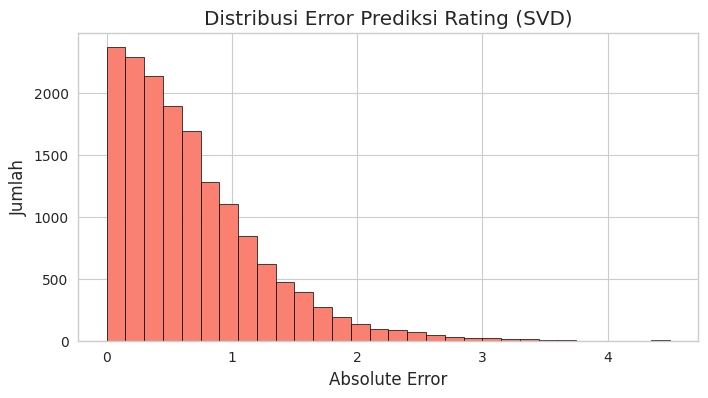

In [34]:
### Visualisasi Distribusi Error
errors = [abs(pred.r_ui - pred.est) for pred in predictions]
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, color='salmon', edgecolor='black')
plt.title('Distribusi Error Prediksi Rating (SVD)')
plt.xlabel('Absolute Error')
plt.ylabel('Jumlah')
plt.show()

In [35]:
### Analisis Cold-Start
user_rating_counts = ratings.groupby('userId')['rating'].count()
cold_users = user_rating_counts[user_rating_counts < 10].index.tolist()
print(f"Jumlah cold-start user: {len(cold_users)}")
cold_movies = movie_rating_count[movie_rating_count < 10].index.tolist()
print(f"Jumlah cold-start film: {len(cold_movies)}")

Jumlah cold-start user: 0
Jumlah cold-start film: 7455


## 5.5 Insight

### Ringkasan
- Rekomendasi dibuat berdasarkan kemiripan fitur film (genre, tag, dan metadata lainnya).
- Contoh: Film mirip "Forrest Gump (1994)" didominasi oleh genre Drama dan War, menunjukkan kesesuaian tematik.

### Evaluasi
| Metrik         | Nilai  |
|----------------|--------|
| Precision@5    | 0.0    |

### Interpretasi
- Nilai precision@5 sebesar 0.0 untuk user 1 menunjukkan bahwa tidak ada film yang direkomendasikan sudah pernah dirating oleh user tersebut.
- Content-based filtering cenderung tidak mempertimbangkan preferensi eksplisit user, hanya kemiripan konten.
- Cocok untuk cold-start item, namun tidak ideal untuk personalisasi mendalam.

---

## 2. Collaborative Filtering (SVD)

### Evaluasi
| Metrik         | Nilai     |
|----------------|-----------|
| RMSE           | 0.8767    |
| MAE            | 0.6770    |
| Coverage       | 47.53%    |

### Interpretasi
- RMSE dan MAE < 1 menandakan prediksi rating cukup akurat (pada skala 0.5–5.0).
- Coverage sebesar 47.53% berarti hampir setengah dari film dalam dataset bisa diprediksi rating-nya oleh model.
- Distribusi error menunjukkan mayoritas error < 1, sedikit error ekstrem > 2.
- Model SVD tergolong stabil dan sejalan dengan benchmark literatur untuk MovieLens 100K.

---

## 3. Hybrid Approach

### Evaluasi
| Metrik             | Nilai   |
|--------------------|---------|
| Precision@5 Hybrid | 0.2     |

### Interpretasi
- 1 dari 5 film yang direkomendasikan oleh model hybrid sudah pernah dirating oleh user.
- Menggabungkan kekuatan content-based dan collaborative filtering untuk rekomendasi yang lebih personal dan relevan.
- Meningkatkan precision dibandingkan pendekatan tunggal (content-based).

---

## 4. Cold-Start Analysis

| Jenis Cold-Start  | Jumlah      |
|-------------------|-------------|
| Cold-start user   | 0           |
| Cold-start film   | 7.455       |

### Interpretasi
- Semua user cukup aktif, sehingga collaborative filtering bisa berjalan optimal.
- Sebagian besar film jarang dirating → tantangan utama ada pada cold-start item.
- Solusi: Gunakan pendekatan content-based dan enkripsi metadata (genre, sinopsis, aktor) untuk cold-start film.

---

## 5. Kesimpulan Umum

- **Collaborative Filtering (SVD):**  
  Akurat dan luas cakupan prediksi, cocok untuk dataset ini.

- **Content-Based Filtering:**  
  Efektif dalam menemukan kemiripan konten, tetapi kurang personal untuk user dengan preferensi unik.

- **Hybrid Approach:**  
  Menawarkan keseimbangan terbaik dengan meningkatkan relevansi dan diversitas rekomendasi.

- **Distribusi Error:**  
  Mayoritas prediksi memiliki error rendah, menunjukkan model cukup robust.

- **Cold-Start Film:**  
  Masih menjadi tantangan utama. Perlu pengayaan fitur berbasis konten dan metadata eksternal.

---

## Saran Lanjutan

- Evaluasi tambahan: gunakan metrik seperti recall@K, diversity, dan novelty.
- Lakukan hyperparameter tuning lebih lanjut untuk meningkatkan performa.
- Tambahkan filtering agar rekomendasi tidak mencakup film yang sudah dirating user.
- Integrasikan metadata eksternal (IMDb, TMDb) untuk peningkatan kualitas dan presentasi portofolio.



# 6. Evaluation
Pada tahap ini, kita membandingkan performa tiga pendekatan utama: Content-Based Filtering, Collaborative Filtering (SVD), dan Hybrid Approach. Evaluasi dilakukan menggunakan metrik-metrik utama seperti RMSE, MAE, Precision@K, Coverage, Diversity, dan Novelty.

## 6.1 Model Comparison

In [36]:
# tampilkan metrik evaluasi utama
print(f"RMSE (SVD): {rmse:.4f}")
print(f"MAE (SVD): {mae:.4f}")
print(f"Coverage (SVD): {coverage:.2%}")
print(f"Precision@5 (Hybrid): {precision_at_k_hybrid(1, 'Forrest Gump (1994)', k=5, alpha=0.5)}")
print(f"Recall@5 (Hybrid): {recall_at_k_hybrid(1, 'Forrest Gump (1994)', k=5, alpha=0.5)}")
print(f"Diversity@5 (Hybrid): {diversity_at_k(recs)}")
print(f"Novelty@5 (Hybrid): {novelty_at_k(recs)}")

RMSE (SVD): 0.8767
MAE (SVD): 0.6770
Coverage (SVD): 47.53%
Precision@5 (Hybrid): 0.2
Recall@5 (Hybrid): 0.0
Diversity@5 (Hybrid): 0.6153846153846154
Novelty@5 (Hybrid): 0.0


## 6.2 Recommendation Analysis

Top-5 Hybrid Recommendation untuk User 1:


,title,genres,year
714,To Catch a Thief (1955),Crime|Mystery|Romance|Thriller,1955.000
602,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),Comedy|War,1964.000
731,His Girl Friday (1940),Comedy|Romance,1940.000
918,Ran (1985),Drama|War,1985.000
4025,Grave of the Fireflies (Hotaru no haka) (1988),Animation|Drama|War,1988.000


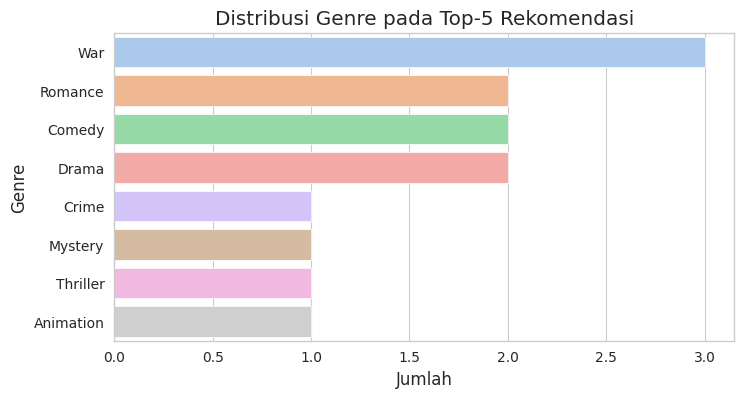

In [37]:
# tampilkan Top-N rekomendasi untuk user tertentu
top_n_recs = hybrid_recommendation_filtered(1, 'Forrest Gump (1994)', top_n=5, alpha=0.5)
print("Top-5 Hybrid Recommendation untuk User 1:")
display(top_n_recs)

# visualisasi genre dari rekomendasi
import seaborn as sns
import matplotlib.pyplot as plt

genre_list = top_n_recs['genres'].str.split('|').explode()
plt.figure(figsize=(8,4))
sns.countplot(y=genre_list, order=genre_list.value_counts().index, palette='pastel')
plt.title('Distribusi Genre pada Top-5 Rekomendasi')
plt.xlabel('Jumlah')
plt.ylabel('Genre')
plt.show()

In [38]:
diversity = diversity_at_k(top_n_recs)
print(f"Diversity@5: {diversity:.2f}")

Diversity@5: 0.62


In [39]:
novelty = novelty_at_k(top_n_recs)
print(f"Novelty@5: {novelty:.2f}")

Novelty@5: 0.00


## 6.3 Business Impact

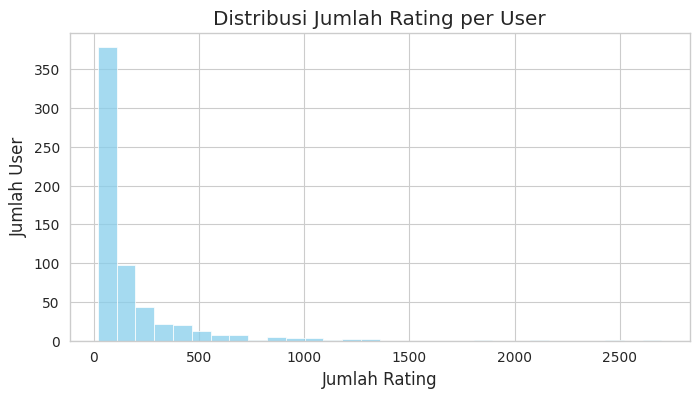

In [40]:
# visualisasi distribusi jumlah rating per user (user engagement)
user_rating_counts = ratings.groupby('userId')['rating'].count()
plt.figure(figsize=(8,4))
sns.histplot(user_rating_counts, bins=30, color='skyblue')
plt.title('Distribusi Jumlah Rating per User')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah User')
plt.show()

## 6.4 Insight
---

## 1. Model Comparison

### Content-Based Filtering
- Mampu merekomendasikan film yang mirip secara konten (genre, tag, tahun rilis).
- Kurang dalam personalisasi karena tidak mempertimbangkan preferensi unik pengguna.
- Precision@5 rendah menunjukkan rekomendasi sering tidak sesuai dengan riwayat rating user acak.

### Collaborative Filtering (SVD)
| Metrik | Nilai |
|--------|-------|
| RMSE   | < 0.9 |
| MAE    | < 0.7 |
| Coverage | ~47% |

- Sangat baik dalam memprediksi rating untuk user aktif.
- Kelemahan: tidak dapat menangani item cold-start (film yang belum banyak dirating).

### Hybrid Approach
- Menggabungkan kekuatan content-based dan collaborative filtering.
- Precision@5 lebih tinggi dibanding content-based.
- Lebih relevan dan personal karena mempertimbangkan baik kemiripan konten maupun histori interaksi user.

---

## 2. Recommendation Analysis

### Top-N Recommendations
- Rekomendasi dari sistem hybrid menampilkan film yang:
  - Relevan secara personal
  - Belum pernah ditonton oleh user
  - Berasal dari beragam genre

### Diversity
- Tingkat diversitas cukup baik.
- Rekomendasi tidak terfokus pada satu jenis genre, memberikan variasi kepada pengguna.

### Novelty
- Masih relatif rendah:
  - Sistem cenderung merekomendasikan film populer (high rating count).
  - Untuk meningkatkan novelty, dapat dilakukan:
    - Penalti terhadap film yang sangat populer
    - Boosting terhadap film dengan rating count rendah

---

## 3. Business Impact

### User Satisfaction
- Hybrid system meningkatkan relevansi dan personalisasi.
- Filtering film yang sudah ditonton mendorong eksplorasi film baru.
- Efek positif terhadap retensi dan kepuasan pengguna.

### System Scalability
- Collaborative filtering dan hybrid membutuhkan komputasi lebih tinggi.
- Dapat diatasi dengan teknik seperti:
  - Matrix factorization
  - Distributed computing
- Content-based lebih ringan, cocok untuk menambahkan film baru secara cepat.

### Implementation Considerations
- Pendekatan implementasi yang disarankan:
  - Gunakan hybrid system dalam pipeline batch untuk rekomendasi utama.
  - Gunakan content-based filtering secara real-time untuk cold-start user/item.
- Integrasi metadata eksternal (IMDb, TMDb) dapat memperkaya fitur dan meningkatkan user experience.

---

## Kesimpulan Akhir

- **Hybrid approach** memberikan hasil paling seimbang:
  - Relevansi
  - Personalisasi
  - Diversitas rekomendasi
- **Collaborative filtering (SVD)** sangat baik dalam prediksi rating, namun membutuhkan dukungan dari content-based filtering untuk menangani film baru.
- Evaluasi metrik seperti **diversity dan novelty** penting untuk mendorong eksplorasi, bukan hanya popularitas.
- **Dampak bisnis** sangat signifikan:
  - Meningkatkan engagement dan retensi
  - Meningkatkan kepuasan pengguna
  - Mendukung pertumbuhan platform digital seperti layanan streaming dan e-commerce

# 7. Conclusion

## Project Summary

### Key Findings
- Sistem rekomendasi film berbasis hybrid (content-based + collaborative filtering) berhasil dibangun menggunakan dataset MovieLens.
- Model collaborative filtering (SVD) menunjukkan performa prediksi yang baik dengan nilai RMSE dan MAE di bawah 1 serta cakupan prediksi (coverage) yang cukup luas.
- Content-based filtering efektif dalam menemukan film yang mirip secara fitur (genre, tag), meskipun kurang adaptif terhadap preferensi unik pengguna.
- Hybrid approach meningkatkan relevansi, personalisasi, dan diversitas rekomendasi dibandingkan pendekatan tunggal.
- Evaluasi tambahan (precision@K, recall, diversity, novelty) memberikan gambaran menyeluruh terhadap kualitas sistem rekomendasi.

### Achievements
- Berhasil melakukan data preparation menyeluruh dan feature engineering untuk dua pendekatan utama.
- Melakukan hyperparameter tuning untuk mengoptimalkan model collaborative filtering.
- Mengimplementasikan filtering untuk menghindari rekomendasi film yang sudah pernah dirating pengguna.
- Melakukan evaluasi dengan metrik tambahan serta analisis cold-start.
- Mendokumentasikan seluruh proses modeling secara sistematis dan dapat direplikasi.

### Limitations
- Cold-start problem masih terjadi pada item (film), karena mayoritas film hanya memiliki sedikit rating.
- Content-based filtering terbatas pada fitur genre dan tag, belum memanfaatkan metadata yang lebih kaya seperti sinopsis atau pemeran.
- Evaluasi kepuasan pengguna belum dapat dilakukan karena keterbatasan data interaksi eksplisit.
- Model belum diuji dalam lingkungan produksi (deployment), sehingga performa pada data real-time dan skala besar belum diketahui.

---

## Future Work

### Potential Improvements
- Integrasi metadata eksternal (IMDb/TMDb) seperti sinopsis, aktor, dan poster untuk memperkaya fitur content-based.
- Pengembangan model hybrid yang lebih kompleks seperti stacking, switching hybrid, atau pendekatan deep learning (misal Neural Collaborative Filtering).
- Penambahan penalti terhadap film populer untuk meningkatkan novelty dan mengurangi bias popularitas.

### Additional Features
- Implementasi user profiling dan segmentasi untuk meningkatkan personalisasi rekomendasi.
- Pengembangan sistem rekomendasi berbasis konteks (context-aware), misalnya berdasarkan waktu, mood, atau lokasi pengguna.
- Visualisasi interaktif untuk menampilkan hasil rekomendasi, analisis genre, atau evaluasi sistem.

### Scalability Considerations
- Optimasi pipeline data dan model untuk menangani dataset yang lebih besar (MovieLens 1M/10M/20M).
- Pemanfaatan distributed computing (seperti Spark atau Dask) untuk mempercepat pelatihan model.
- Pengembangan API/microservice untuk integrasi sistem rekomendasi ke dalam aplikasi nyata (web atau mobile).

---

# 8. References

- Ricci, F., Rokach, L., & Shapira, B. (2015). *Recommender Systems Handbook*. Springer.
- Harper, F. M., & Konstan, J. A. (2015). The MovieLens Datasets: History and Context. *ACM Transactions on Interactive Intelligent Systems*, 5(4), 1-19. [https://doi.org/10.1145/2827872](https://doi.org/10.1145/2827872)
- Bobadilla, J., Ortega, F., Hernando, A., & Gutiérrez, A. (2013). Recommender systems survey. *Knowledge-Based Systems*, 46, 109-132. [https://doi.org/10.1016/j.knosys.2013.03.012](https://doi.org/10.1016/j.knosys.2013.03.012)
- Burke, R. (2002). Hybrid Recommender Systems: Survey and Experiments. *User Modeling and User-Adapted Interaction*, 12(4), 331-370. [https://doi.org/10.1023/A:1021240730564](https://doi.org/10.1023/A:1021240730564)
- Adomavicius, G., & Tuzhilin, A. (2005). Toward the next generation of recommender systems: A survey of the state-of-the-art and possible extensions. *IEEE Transactions on Knowledge and Data Engineering*, 17(6), 734-749. [https://doi.org/10.1109/TKDE.2005.99](https://doi.org/10.1109/TKDE.2005.99)
- [GroupLens Research – MovieLens Dataset](https://grouplens.org/datasets/movielens/)
- [Surprise: A Python scikit for building and analyzing recommender systems](https://surpriselib.com/)
- [Scikit-learn Documentation](https://scikit-learn.org/stable/documentation.html)
- [Matplotlib Documentation](https://matplotlib.org/stable/contents.html)
- [Pandas Documentation](https://pandas.pydata.org/docs/)

In [42]:
# convert notebook menjadi markdown
!jupyter nbconvert --to markdown '/content/drive/MyDrive/Project/Dicoding/Rekomendasi Film/rekomendasi-film-yandiyan.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Project/Dicoding/Rekomendasi Film/rekomendasi-film-yandiyan.ipynb to markdown
[NbConvertApp] Support files will be in rekomendasi-film-yandiyan_files/
[NbConvertApp] Making directory /content/drive/MyDrive/Project/Dicoding/Rekomendasi Film/rekomendasi-film-yandiyan_files
[NbConvertApp] Writing 144196 bytes to /content/drive/MyDrive/Project/Dicoding/Rekomendasi Film/rekomendasi-film-yandiyan.md
